
# <font color=blue> Thien NGUYEN, Junji LI, Kamelia AMZAL </font> 

Ce projet est basé sur l'article [CCF: Fast and Scalable Connected Component Computation in MapReduce](https://www.cse.unr.edu/~hkardes/pdfs/ccf.pdf) écrit par H.Kardes, S.Agrawal, X.Wang et A.Sun en 2014.

Nous proposons deux variants de l'algorithme en Pyspark RDD, comme dans l'article. Les 2 variants ont pris 8 itération (3 en moins) 12 minutes (3 fois) comparé à l'article.

Nous avons constaté également que pour le grand composant, il y a 855802 (855801 + 1 car son id représente le composant) noeuds.


## Exemple à Tester

In [0]:
# test_case_1 = sc.parallelize([("A","B"), ("B","C"), ("B","D"), ("D","E"), ("F","G"), ("G", "H")])
# test_case_1.collect()
test_case_1 = sc.parallelize([(1, 2), (2, 3), (2, 4), (4, 5), (6,7), (7, 8)])
test_case_1.collect()

Out[1]: [(1, 2), (2, 3), (2, 4), (4, 5), (6, 7), (7, 8)]

In [0]:
def rdd_map_phase(rdd):
    ### Map ###
    # transformer (A -> B) à  (A -> B), (B -> A) ; ...
    return rdd.map(lambda x: [(x[0], x[1]),(x[1], x[0])]).flatMap(lambda x: x)

def emit_dedup_phase(emit):
    ### CCF-dedub ###
    # Transformation [(B, A), (B, A), ...] à (B, A)
    return emit.map(lambda x: (x, [])).reduceByKey(lambda x, y: x).map(lambda x: x[0])

def ccf_iterate(rdd, counter_pair):
    ### Reduce ###
    # transformer (A -> B), (A -> D), (A -> C) à (A -> [B, D, C]) ; ...
    rdd = rdd.map(lambda x: (x[0], [x[1]])).reduceByKey(lambda x, y: x  + y)

    # trouver le min pour A -> [B, D, C] 
    # Transformation de (A -> [B, D, C]) à (A -> [B, D, C], A)
    # similairement, (B -> [A, ...]) à (B -> [A, ...], A)
    minEachKey = rdd.map(lambda x: (x[0], x[1], min(x[1]))).map(lambda x: (x[0], x[1], min(x[2], x[0]))).persist() 

    # comparer min et key, si min < key, on emit (min, key)
    # (A -> [B, D, C], A) : on emit rien
    # (B -> [A, ...], A) : on emit (B, A)
    emit_1 = minEachKey.filter(lambda x: x[2] < x[0]).map(lambda x: (x[0], x[2])) 
    # exclure min de valueList
    # transformation de (B -> [A, ...], A)  à  (B -> [...], A)
    emit_2 = minEachKey.filter(lambda x: x[2] < x[0]).map(lambda x: (x[0], [y for y in x[1] if y != x[2]], x[2])).persist()

    # Increase counter
    counter_pair += emit_2.map(lambda x: len(x[1])).reduce(lambda x, y: x+ y) 

    # coupler valueList avec min
    # transformation (B -> [M, N], A) à (M, A), (N, A)
    emit_2 = emit_2.filter(lambda x: len(x[1]) != 0).map(lambda x: [(y, x[2]) for y in x[1]]).flatMap(lambda x: x)

    # combiner (key, min) et (value, min)
    emit = emit_1.union(emit_2)
    
    return emit, counter_pair

In [0]:
def ccf_iterate_secondary_sort(rdd, counter_pair):
    ### Reduce ###
    # transformer (A -> B), (A -> D), (A -> C) à (A -> [B, C, D]) ; ...
    # valueList[0] est le min parmi valueList
    rdd = rdd.map(lambda x: (x[0], [x[1]])).reduceByKey(lambda x, y: x  + y)
    rdd = rdd.map(lambda x: (x[0], sorted(x[1]))) # tri secondaire

    # if(minValue < key) : 
    #     emit(key, minValue)
    # transformation [(A -> [B, C, D]), (P -> [M, N])] à [(P -> [M, N])]
    rdd = rdd.filter(lambda x: x[1][0] < x[0]).persist()
    # emit (P, M) depuis (P -> [M, N])
    emit_1 = rdd.map(lambda x: (x[0], x[1][0]))

    # valueList = valueList[1:] (en cas de liste vide, supprimer), garder la minValue
    # transformation (P -> [M, N]) à (P -> [N], M)
    rdd = rdd.map(lambda x: (x[0], x[1][1:], x[1][0])).filter(lambda x: len(x[1]) > 0).persist()
    
    if rdd.count() > 0:
        counter_pair += rdd.map(lambda x: len(x[1])).reduce(lambda x, y: x + y)
        # emit(value, minValue) for value in valueList
        # emit (N, M), (O, M) depuis (Q->[N, O], M)
        emit_2 = rdd.flatMap(lambda x: [(val, x[2]) for val in x[1]])
        emit = emit_1.union(emit_2)
    else: 
        counter_pair = 0
        emit = emit_1

    return emit, counter_pair

In [0]:
#main

def FCC(rdd, use_secondary_sort=False):
    new_pair = 1
    while (new_pair > 0):
        ### Map ###
        rdd = rdd_map_phase(rdd)

        ### reduce ###
        if not use_secondary_sort:
            rdd, new_pair = ccf_iterate(rdd, 0)
        else:
            rdd, new_pair = ccf_iterate_secondary_sort(rdd, 0)
        print("new_pair = ", new_pair)

        ### dedup ###
        rdd = emit_dedup_phase(rdd)
    
    return rdd

In [0]:
FCC(test_case_1, True).collect()

new_pair =  4
new_pair =  9
new_pair =  4
new_pair =  0
Out[85]: [(8, 6), (2, 1), (3, 1), (4, 1), (5, 1), (7, 6)]

In [0]:
FCC(test_case_1).collect()

new_pair =  4
new_pair =  9
new_pair =  4
new_pair =  0
Out[81]: [(8, 6), (2, 1), (3, 1), (4, 1), (5, 1), (7, 6)]

## Google Web Graph

In [0]:
%sh 
# tester sur Google Web Graph
curl -sk http://snap.stanford.edu/data/web-Google.txt.gz | gzip -d | tail -n +5 > data.txt && cat data.txt | head -n 10

0	11342
0	824020
0	867923
0	891835
11342	0
11342	27469
11342	38716
11342	309564
11342	322178
11342	387543


In [0]:
# Chargement du fichier de données et transformation en paires d'entiers
web_graph_rdd = sc.textFile("file:/databricks/driver/data.txt").map(lambda line: line.split("\t")).map(lambda x: (int(x[0]), int(x[1])))

# Compter les arêtes
c1 = web_graph_rdd.count()
print(f"{c1/1e6:.2f}M arêtes")

5.11M arêtes


In [0]:
# 12 min avec cache ou persistant
a = FCC(web_graph_rdd, True)
a.collect()

new_pair =  8670951
new_pair =  4821525
new_pair =  3278772
new_pair =  3888454
new_pair =  1905323
new_pair =  86783
new_pair =  1318
new_pair =  0
Out[86]: [(19594, 0),
 (30730, 0),
 (778, 0),
 (52618, 0),
 (130954, 0),
 (339082, 0),
 (652810, 0),
 (452746, 0),
 (139786, 0),
 (70666, 0),
 (161674, 0),
 (7306, 0),
 (76426, 0),
 (466570, 0),
 (589450, 0),
 (68362, 0),
 (653194, 0),
 (99082, 0),
 (873226, 0),
 (259594, 0),
 (485770, 0),
 (413194, 0),
 (352522, 0),
 (518026, 0),
 (554890, 0),
 (581386, 0),
 (605578, 0),
 (775690, 0),
 (855178, 0),
 (11146, 0),
 (22666, 0),
 (129418, 0),
 (140170, 0),
 (242698, 0),
 (255370, 0),
 (301066, 0),
 (343690, 0),
 (442378, 0),
 (446218, 0),
 (552202, 0),
 (562186, 0),
 (878986, 0),
 (17674, 0),
 (144394, 0),
 (251914, 0),
 (126346, 0),
 (499594, 0),
 (228874, 0),
 (10762, 0),
 (280330, 0),
 (564490, 0),
 (891274, 0),
 (81034, 0),
 (88330, 0),
 (151690, 0),
 (253834, 0),
 (258442, 0),
 (308746, 0),
 (553354, 0),
 (731914, 0),
 (812554, 0),
 (8678

In [0]:
b = FCC(web_graph_rdd, False)
b.collect()

new_pair =  8552232
new_pair =  4758451
new_pair =  3278772
new_pair =  3888454
new_pair =  1905323
new_pair =  86783
new_pair =  1318
new_pair =  0
Out[92]: [(30730, 0),
 (778, 0),
 (652810, 0),
 (139786, 0),
 (70666, 0),
 (68362, 0),
 (99082, 0),
 (873226, 0),
 (259594, 0),
 (413194, 0),
 (775690, 0),
 (581386, 0),
 (352522, 0),
 (446218, 0),
 (562186, 0),
 (442378, 0),
 (301066, 0),
 (242698, 0),
 (552202, 0),
 (17674, 0),
 (251914, 0),
 (144394, 0),
 (228874, 0),
 (564490, 0),
 (10762, 0),
 (280330, 0),
 (88330, 0),
 (731914, 0),
 (812554, 0),
 (867850, 0),
 (308746, 0),
 (245002, 0),
 (319498, 0),
 (734218, 0),
 (723466, 0),
 (376330, 0),
 (87562, 0),
 (348682, 0),
 (848650, 0),
 (431626, 0),
 (411658, 0),
 (526858, 0),
 (658186, 0),
 (533002, 0),
 (685834, 0),
 (806410, 0),
 (260362, 0),
 (130570, 0),
 (828682, 0),
 (587530, 0),
 (304138, 0),
 (728074, 0),
 (681226, 0),
 (400906, 0),
 (86026, 0),
 (314890, 0),
 (188170, 0),
 (350986, 0),
 (103690, 0),
 (506122, 0),
 (186634, 0),


## Distribution de Taille des Composants Connectés

In [0]:
# Compter les composants
# transformation [(id_vertex, id_CC), ...] à [(length_CC, nb_CC)]
# [(id_vertex=30730, id_CC=0), (id_vertex=778, id_CC=0), (id_vertex=5261, id_CC=1), (id_vertex=13095, id_CC=2), ...] 
# à [(nb=2, CC_id=0), (nb=1, CC_id=1), (nb=1, CC_id=2) ...] 
# à [(vertices_nb=2, CC_nb=1), (vertices_nb=1, CC_nb=2), ...]
count_components = a.groupBy(lambda x: x[1]).mapValues(len).groupBy(lambda x: x[1]).mapValues(len)

# Sauvegarder les résultats dans un fichier
count_components.coalesce(1).saveAsTextFile("./count_components")

In [0]:
%sh
head ./count_components/part-00000 -n 100

(1, 783)
(2, 503)
(3, 279)
(4, 197)
(5, 178)
(6, 150)
(7, 94)
(8, 68)
(9, 63)
(10, 43)
(11, 43)
(12, 31)
(13, 30)
(14, 29)
(15, 25)
(16, 19)
(17, 15)
(18, 21)
(19, 24)
(403, 1)
(20, 35)
(21, 9)
(22, 11)
(23, 4)
(24, 4)
(25, 3)
(26, 6)
(27, 3)
(28, 4)
(29, 3)
(30, 2)
(31, 5)
(32, 3)
(33, 3)
(34, 2)
(35, 6)
(36, 2)
(39, 2)
(40, 4)
(41, 1)
(42, 4)
(44, 4)
(46, 1)
(49, 2)
(51, 3)
(53, 1)
(55, 4)
(59, 2)
(60, 2)
(61, 1)
(65, 1)
(68, 1)
(74, 1)
(75, 1)
(77, 1)
(80, 1)
(91, 1)
(99, 1)
(114, 1)
(173, 1)
(855801, 1)
(252, 1)
(318, 1)
(383, 1)


In [0]:
# Lire le fichier de résultats
with open("./count_components/part-00000", 'r') as file:
    lines = file.readlines()

# Nettoyer les lignes et préparer les données pour une sauvegarde propre
cleaned_lines = [line.strip().replace('(', '').replace(')', '').replace(',', '\t') for line in lines]

# Sauvegarder les lignes nettoyées dans un nouveau fichier
with open("./counts.txt", 'w') as out_file:
    for line in cleaned_lines:  # Écrire seulement les 10 premières lignes
        out_file.write(f"{line}\n")


In [0]:
%sh
# ls
head counts.txt -n 10

1	 783
2	 503
3	 279
4	 197
5	 178
6	 150
7	 94
8	 68
9	 63
10	 43


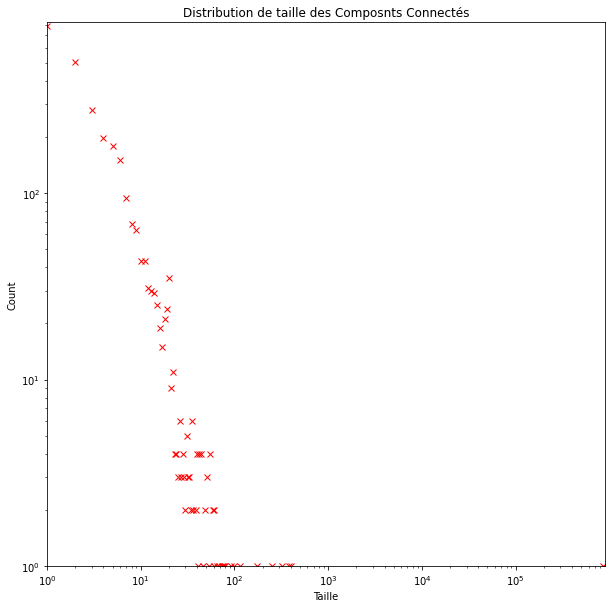

In [0]:
import matplotlib.pyplot as plt
import numpy as np

counts = np.loadtxt("counts.txt")

plt.figure(figsize=(10,10))
X = counts[:, 0]
Y = counts[:, 1]
plt.plot(X, Y, 'rx')
plt.xlim(left=1)  
plt.ylim(bottom=1) 

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Taille')
plt.ylabel('Count')
plt.title('Distribution de taille des Composnts Connectés')

plt.show()